# IRIS data classification
1. closest to the class center
2. Full Bayes with Gaussian Model
3. Naive Bayes with conditionally independent Gaussian

In [36]:
%matplotlib inline

install sklearn if not installed
```
!pip3 install sklearn
```

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets

In [38]:
iris = sklearn.datasets.load_iris()
dir(iris)

['DESCR', 'data', 'feature_names', 'filename', 'target', 'target_names']

## We use the first two features in the beginning
- Binary classification: Setosa vs The Others

In [39]:
data = iris.data[:, :2]
y = iris.target
print (data.shape)

(150, 2)


In [40]:
sel0 = y == 0 # setosa
sel1 = sel0 == False # the others
groups = [sel0, sel1]
nclasses = 2
nfeatures = 2

### scatter plot

In [41]:
from matplotlib.patches import Ellipse

def scatter(centers=None, covs=None, scale=None):
    fig, ax = plt.subplots(figsize=(7,5))
    colors = ['pink', 'skyblue']
    for k in range (nclasses):
        s = groups[k]
        ax.scatter (data[s,0], data[s,1], color=colors[k])
    ax.set_xlabel (iris.feature_names[0])
    ax.set_ylabel (iris.feature_names[1])
    #
    if centers is not None:
        center_color = ['r', 'b']
        for k in range(nclasses):
            ax.scatter(centers[k,0], centers[k,1], color=center_color[k], s=200, marker='*')
    #
    if covs is not None:
        colors = ['r', 'b']
        for k in range(nclasses):
            w, v = np.linalg.eig(covs[k]) # C = V W V'
#             print ('eig: ', w, v)
            if w[0] < w[1]:
                w = np.sort(w)[::-1] # 
                v = v[:, w.argsort()] # 
#                 print ('\teig: ', w, v)

            xaxis = v[:,0] # 
#             print ('xaxis: ', xaxis, '  w: ', w)
            theta = np.arctan2(xaxis[1], xaxis[0])
#             print ('theta: ', np.degrees(theta))
            scale = 2 if scale is None else scale
            el = Ellipse (centers[k], 
                          width=2*np.sqrt(w[0]*scale), # reverse x, y since the last is the greatest
                          height=2*np.sqrt(w[1]*scale), 
                          angle=np.degrees(theta), 
                          alpha=0.3, color=colors[k])
            ax.add_artist(el)
    #        
    return fig, ax

(<Figure size 504x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x23ff7dae470>)

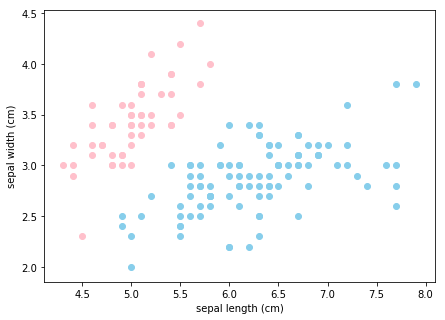

In [42]:
scatter()

## Method 1: Closest to the cluster center

### compute cluster centers

In [43]:
means = np.zeros ((nclasses, nfeatures))
for k in range(nclasses):
    means[k] = data[groups[k]].mean(axis=0)
print ('means = ', means)

means =  [[5.006 3.428]
 [6.262 2.872]]


(<Figure size 504x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x23ff7e23f28>)

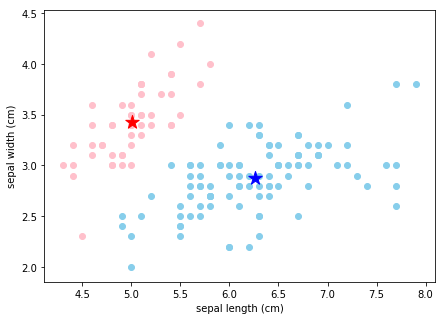

In [44]:
scatter(centers=means)

### distance() and predict()

In [45]:
def distance(xy, ab):
    return np.sqrt( np.power(xy[0]-ab[0],2.) + np.power(xy[1]-ab[1],2.))
#
def closest_predict(xy):
    d0 = distance (xy, means[0])
    d1 = distance (xy, means[1])
    if d0 < d1: return 0
    else: return 1
#

### prediction map computation

In [46]:
step=0.1
xx = np.arange(4.0, 8.2, step=step)
yy = np.arange(1.8, 4.6, step=step)
print ('xx.shape={}  yy.shape={}'.format(xx.shape, yy.shape))
# make grid
xgrid = np.empty((yy.shape[0], xx.shape[0]))
ygrid = np.empty((yy.shape[0], xx.shape[0]))
pgrid = np.empty((yy.shape[0], xx.shape[0]))
for i in range(pgrid.shape[0]):
    for j in range(pgrid.shape[1]):
        ygrid[i,j] = yy[i]
        xgrid[i,j] = xx[j]
        pgrid[i,j] = closest_predict ((xx[j], yy[i]))
#

xx.shape=(42,)  yy.shape=(28,)


### classification map

Text(0.5, 1.0, 'Classification by The closest to the center point.')

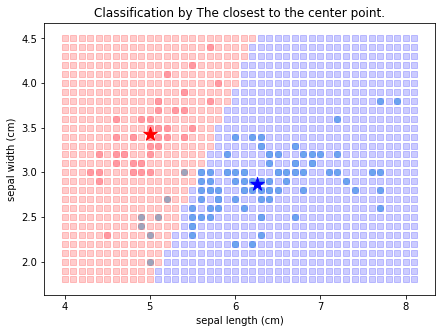

In [47]:
fig, ax = scatter(centers=means)
setosa = pgrid < 1
theothers = pgrid > 0
ax.scatter (xgrid[setosa].ravel(), ygrid[setosa].ravel(), color='r', alpha=0.2, marker='s')
ax.scatter (xgrid[theothers].ravel(), ygrid[theothers].ravel(), color='b', alpha=0.2, marker='s')
ax.set_title ('Classification by The closest to the center point.')

## Method 2: Full Gaussian modeling and closest to the center with scale

- Naive Bayes:
https://scikit-learn.org/stable/modules/naive_bayes.html
- What we do below is full Bayesian

### Sample Covariance Matrix

In [48]:
def cov (X, mean):
    C = np.zeros((X.shape[1], X.shape[1]))
    for i in range(X.shape[0]):
        z = X[i] - mean
        a = z[:, np.newaxis]
        C += a @ a.transpose()
    C /= (X.shape[0] - 1) # unbiased. But -1 is not necessary when we have many data like this example.
    return C

In [49]:
covs = [cov(data[groups[k]], means[k]) for k in range(nclasses) ]
covs

[array([[0.12424898, 0.09921633],
        [0.09921633, 0.1436898 ]]), array([[0.43934949, 0.12215758],
        [0.12215758, 0.11072323]])]

In [50]:
# numpy funtion for covariance
covs_np = [ np.cov( data[groups[k]].transpose() ) for k in range(nclasses) ]
covs_np

[array([[0.12424898, 0.09921633],
        [0.09921633, 0.1436898 ]]), array([[0.43934949, 0.12215758],
        [0.12215758, 0.11072323]])]

(<Figure size 504x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x23ff7e23518>)

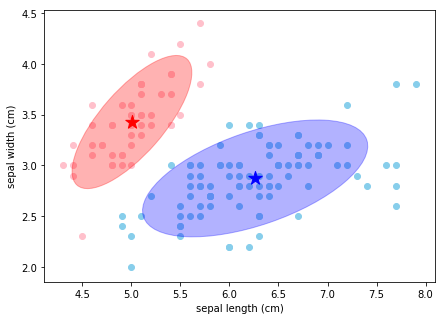

In [51]:
scatter(centers=means, covs=covs, scale=3)

### 2D Gaussain PDF as Conditional Likelihood Functions
- given the class label

In [52]:
def Gaussian2d(x, mean, cov):
    a = np.dot( np.linalg.inv(cov), x-mean)
    f = np.exp( np.dot(x-mean, a) / -2) / np.sqrt( (2*np.pi)**2 * np.linalg.det(cov) )
    return f

In [53]:
x = np.array([[4.6, 2.6]])
Gaussian2d(x[0], means[0], covs[0])

0.12792515163397944

In [54]:
# scipy function
import scipy.stats
gpdf2d = scipy.stats.multivariate_normal.pdf
print('Gaussian2d: ', gpdf2d([4.6, 2.6], mean=means[0], cov=covs[0]) )

Gaussian2d:  0.12792515163397936


### Prior Distribution

In [55]:
Prior = np.array([ groups[k].mean() for k in range(nclasses)])
Prior

array([0.33333333, 0.66666667])

### Feature space separation

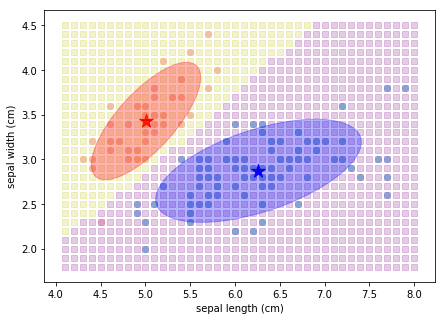

In [56]:
setosa = []
theothers = []

fig, ax = scatter (centers=means, covs=covs, scale=3)
step = 0.1
xx = np.arange(4.1, 8.1, step=step)
yy = np.arange(1.8, 4.6, step=step)
for x in xx:
    for y in yy:
        xy = np.array([x, y])
        g0 = Gaussian2d(xy, means[0], covs[0])
        g1 = Gaussian2d(xy, means[1], covs[1])
        posterior0 = g0 * Prior[0] # / evidence
        posterior1 = g1 * Prior[1]
        
        if posterior0 > posterior1: # this is setosa
            setosa.append(xy)
#             ax.scatter(xy[0], xy[1], marker='s', alpha=0.2, color='y')
        else:
            theothers.append(xy)
#             ax.scatter(xy[0], xy[1], marker='s', alpha=0.2, color='purple')
setosa = np.array(setosa)
theothers = np.array(theothers)
ax.scatter(setosa[:,0], setosa[:,1], marker='s', alpha=0.2, color='y')
ax.scatter(theothers[:,0], theothers[:,1], marker='s', alpha=0.2, color='purple')

## Method 3: Naive Bayes
- conditional indepence assumption for the features
$$
    p(x_1, x_2 | C) = p(x_1 | C) p(x_2 | C)
$$

In [57]:
import sklearn.naive_bayes
gnb = sklearn.naive_bayes.GaussianNB()

### Naive Bayes fit (sklearn)

In [74]:
gnb = gnb.fit (data, sel0)

In [75]:
gnb.predict([[5.0, 3.0]])

array([ True])

### Grid points generation in feature space for classification map

In [78]:
xg, yg = np.meshgrid(xx, yy)

grid = np.concatenate ((xg[np.newaxis,:], yg[np.newaxis,:]))

xg.shape, grid.shape

In [79]:
grid = grid.transpose((1,2,0))
grid.shape

(28, 40, 2)

In [80]:
gridarr = grid.reshape(-1,2)
gridarr.shape

(1120, 2)

In [81]:
gridarr[0], gridarr[-1]

(array([4.1, 1.8]), array([8. , 4.5]))

### Prediction for the features

In [82]:
pred = gnb.predict(gridarr)

In [91]:
pred[:6]

array([False, False, False, False, False, False])

In [93]:
print(f'Proportion of Setosa in the feature gird : {pred.sum() / pred.shape[0]:.3f}')

Proportion of Setosa in the feature gird : 0.290


In [94]:
setosa_gnb = gridarr[pred] # grid points that belong to Setosa
theothers_gnb = gridarr[pred==False] # grid points for others

### Naive Bayes, Parameters

In [95]:
# mean locations
gnb.theta_

array([[6.262, 2.872],
       [5.006, 3.428]])

In [96]:
means # our computation of the mean location (notice, reversed order!)

array([[5.006, 3.428],
       [6.262, 2.872]])

In [97]:
# isotropic, diagonal. sigam is the variance of each feature per class
gnb.sigma_

array([[0.434956, 0.109616],
       [0.121764, 0.140816]])

In [88]:
# class prior probabilities
gnb.class_prior_

array([0.66666667, 0.33333333])

### Feature Map using the prediction on the feature grids

Text(0.5, 1.0, 'feature space separation by NBGaussian()')

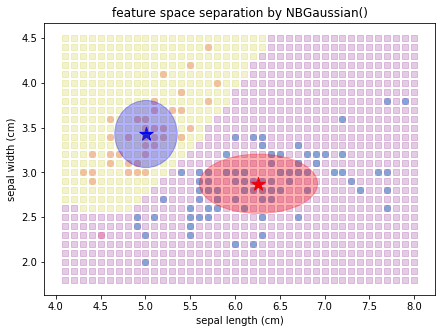

In [98]:
covs0 = [np.diag(gnb.sigma_[k]) for k in range(nclasses)]
fig, ax = scatter (centers=gnb.theta_, covs=covs0, scale=1)
ax.scatter(setosa_gnb[:,0], setosa_gnb[:,1], marker='s', alpha=0.2, color='y')
ax.scatter(theothers_gnb[:,0], theothers_gnb[:,1], marker='s', alpha=0.2, color='purple')
ax.set_title('feature space separation by NBGaussian()')

Conclusion?

Naive Bayes is not bad. Actually it seems quite good in spite of its simplicity.

**Q. Fit the Naive Bayes Classifier using all the four features for three species**

1. Draw classification maps for other feature pairs, such as (sepal length, petal length), (sepal width, petal, length), etc, since we may hardly visualize the 4-dimensional feature space in 2D.

2. Use `sklearn` utility functions for `train_test_split()` and Cross Validation Technique to obtain the potential (predictive) performance (accuracy) of the Naive Bayes Classifier.

# EOF